In [ ]:
import torch

import matplotlib.pyplot as plt

import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

import seaborn as sns

from functions.dl.convenience_functions import to_device, trialDir
from functions.dl.data_classes import SpectroDataset, SpectroDataLoader
from functions.dl.data_functions import splitDataset, load_data, load_model, train_model, getBestModel
from functions.dl.network_components import EarlyStopping, AudioToLogSpectrogram

ray.init(ignore_reinit_error=True)
print("Ray is initialized!")

CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA = 1
%load_ext tensorboard

f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-12-28 18:16:14,528	INFO worker.py:2007 -- Started a local Ray instance.


Ray is initialized!


f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# https://medium.com/biased-algorithms/hyperparameter-tuning-with-ray-tune-pytorch-d5749acb314b
max_epochs = 25
# Define hyperparameter search space
config = {
    "lr": tune.loguniform(1e-5, 1e-2),          # Learning rate between 1e-5 and 1e-2
    "batch_size": tune.choice([8, 16, 32, 64, 128]), # qlograndint(32, 1024, q=2)
    "nfft" : tune.choice([512, 1024, 2048, 4096, 8192]),
    "scale" : tune.uniform(0.5, 4),
    "power" : tune.uniform(0.5, 4),
    "patience" : tune.choice([2, 3, 5, 7, 9]),
    "EarlyDelta" : tune.uniform(0.0015, 0.1),
    "epochs" : tune.randint(15, max_epochs),
    "l1" : tune.loguniform(0.0005, 0.004),
    "l2" : tune.loguniform(0.00075, 0.003)
    #"optimizer": tune.choice(["adam", "sgd"]),  # Optimizer choice: Adam or SGD
    # "layer_size": tune.randint(64, 256),        # Random integer for layer size (hidden units)
    # "dropout_rate": tune.uniform(0.1, 0.5)      # Dropout rate between 0.1 and 0.5
}

In [4]:
trainable_with_resources = tune.with_resources(
    train_model, 
    resources={"cpu": 16, "gpu": 1, "accelerator_type:G":1}
)

optuna_search = OptunaSearch(
    metric=["loss", "accuracy"],
    mode=["min", "max"]
)

hyperopt_search = HyperOptSearch(
    metric="loss",
    mode="min",  # Minimize loss
    # points_to_evaluate # Use when some good hyperparameters are known as initial values
)

asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='accuracy',
    mode='max',
    max_t=max_epochs,
    grace_period=10,
    brackets=1,
)

# Pass the search algorithm to Ray Tune
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=config,
    # tune_config=tune.TuneConfig(search_alg=hyperopt_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=2),
    tune_config=tune.TuneConfig(search_alg=optuna_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=4,),
    run_config=tune.RunConfig(storage_path='D:/ProgramFiles/RayResults', name="results")
)
tuner.fit()

(train_model pid=22976) 13119
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23853551_audio.flac


(pid=gcs_server) [2025-12-28 18:16:42,285 E 26448 19292] (gcs_server.exe) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_model pid=22976) 13120
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23853553_audio.flac
(train_model pid=22976) 13121
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23862849_audio.flac
(train_model pid=22976) 13122
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\24104283_audio.flac
(train_model pid=22976) 13123
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\25408667_audio.flac
(train_model pid=22976) 13124
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26172099_audio.flac
(train_model pid=22976) 13125
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26563106_audio.flac
(train_model pid=22976) 13126
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26747817_audio.flac
(train_model pid=22976) 13127
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26755651_audio.flac
(train_m

(raylet) [2025-12-28 18:16:47,063 E 7136 14060] (raylet.exe) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_model pid=22976) 13130
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26831857_audio.flac
(train_model pid=22976) 13131
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26834562_audio.flac
(train_model pid=22976) 13132
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26847205_audio.flac
(train_model pid=22976) 13133
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26847200_audio.flac
(train_model pid=22976) 13134
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26846776_audio.flac
(train_model pid=22976) 13135
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26847701_audio.flac
(train_model pid=22976) 13136
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26847717_audio.flac
(train_model pid=22976) 13137
(train_model pid=22976) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26880658_audio.flac
(train_m

2025-12-28 18:17:09,682	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-12-28 18:17:09,706	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'D:/ProgramFiles/RayResults/results' in 0.0227s.
2025-12-28 18:17:14,249	INFO tune.py:1041 -- Total run time: 54.84 seconds (50.23 seconds for the tuning loop).
2025-12-28 18:17:14,249	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="D:/ProgramFiles/RayResults/results", trainable=...)
2025-12-28 18:17:14,259	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/re

ResultGrid<[
  Result(
    metrics={'loss': 3.3006805181503296, 'accuracy': 0.1},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_cc8c8b',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829',
    filesystem='local',
    checkpoint=None
  )
]>

In [5]:
model, df = getBestModel(return_df=True)

2025-12-28 18:17:21,701	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


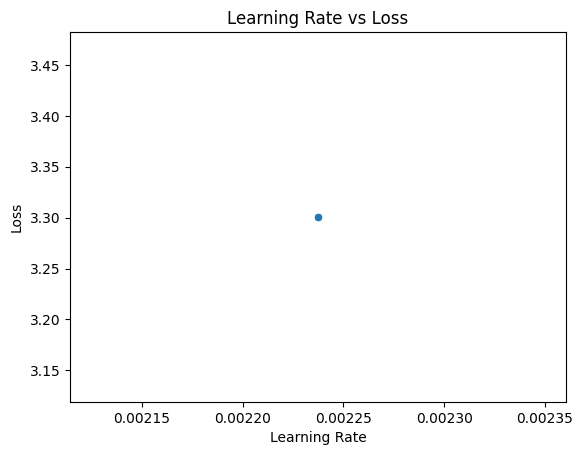

In [6]:
# Plot loss vs learning rate
sns.scatterplot(x="config/lr", y="loss", data=df)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
plt.show()

In [7]:
%tensorboard --logdir runs/single_points/

Reusing TensorBoard on port 6008 (pid 22976), started 6 days, 6:42:11 ago. (Use '!kill 22976' to kill it.)

In [11]:
recording_path="Z:\\Audio_data\\Dawn_chorus_conversion_flac"
label_path="F:\\Persönliches\\Git\\BioOTon"
batch_size = 8

ds = SpectroDataset(recording_path, label_path, device = 'cuda')
train_indices, test_indices, val_indices  = splitDataset(ds)
test_dataloader = SpectroDataLoader(ds, batch_size, samples= test_indices[:150], device = "cuda")

4373
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21473304_audio.flac
4374
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21502802_audio.flac
4375
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21525865_audio.flac
4376
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21556705_audio.flac
4377
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21568713_audio.flac
4378
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21586206_audio.flac
4379
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21630314_audio.flac
4380
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21689604_audio.flac
4381
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21725964_audio.flac
4382
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21741886_audio.flac
4383
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21761018_audio.flac
4384
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21762672_audio.flac
4385
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21817477_audio.flac
4386
Getting Z:\Audio_dat

2025-12-28 18:22:12,059	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


2025-12-28 18:22:12,605	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')
2025-12-28 18:22:12,777	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}
Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


2025-12-28 18:22:12,937	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')
2025-12-28 18:22:13,127	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


2025-12-28 18:22:13,283	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}
Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


2025-12-28 18:22:13,456	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')
2025-12-28 18:22:13,622	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}
Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


2025-12-28 18:22:13,795	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')
2025-12-28 18:22:13,976	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}
Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


2025-12-28 18:22:14,158	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')
2025-12-28 18:22:14,334	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}
Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


2025-12-28 18:22:14,511	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')
2025-12-28 18:22:14,667	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}
Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


2025-12-28 18:22:14,829	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')
2025-12-28 18:22:15,007	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}
Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


2025-12-28 18:22:15,209	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


2025-12-28 18:22:15,503	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')
2025-12-28 18:22:15,665	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_b05829ca: FileNotFoundError('Could not fetch metrics for train_model_b05829ca: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_b05829')


Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}
Best Hyperparameters: {'lr': 0.0022374241845109825, 'batch_size': 8, 'nfft': 2048, 'scale': 1.2689702469589914, 'power': 2.4269966360193176, 'patience': 7, 'EarlyDelta': 0.030527228554045563, 'epochs': 21, 'l1': 0.0015170360019768742, 'l2': 0.001029313491829506}


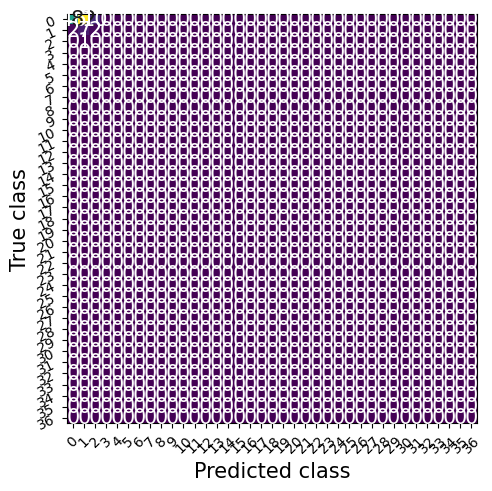

Recall of the custom cnn: tensor(0.3232, device='cuda:0')
F1-score of the custom cnn: tensor(0.2111, device='cuda:0')
Overall accuracy of the custom cnn: tensor(0.3232, device='cuda:0')


In [12]:
preds = torch.Tensor().to(device)
labs = torch.Tensor().to(device)

# Get predictions and corresponding real labels
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        model = getBestModel()
        inp = model(inputs)

        preds = torch.cat((preds, inp), 0).to(device)
        labs = torch.cat((labs, labels), 0)
        labs = labs.type(torch.LongTensor).to(device)


# Confusion Matrix
metric = tc.MulticlassConfusionMatrix(37).to(device)
metric.update(preds, labs)

fig_, ax_ = metric.plot()
plt.show()


# Compute recall
recall = tc.Recall(task="multiclass", average='macro', num_classes=37).to(device)
recall(preds, labs)
print("Recall of the custom cnn:", recall.compute())

# Compute F1-score
f1 = tc.MulticlassF1Score(37).to(device)
f1(preds, labs)
print("F1-score of the custom cnn:", f1.compute())


# Compute overall accuracy
oa = tc.MulticlassAccuracy(37).to(device)
oa(preds, labs)
print("Overall accuracy of the custom cnn:", oa.compute())